# This notebook is used to Train LSTM networks for sentiment analysis using Keras

### Define the necessary imports

In [63]:
from keras.layers.core import Activation, Dropout, SpatialDropout1D, Dense
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM

import numpy as np
import collections
import matplotlib.pyplot as plt
import nltk
from sklearn.model_selection import train_test_split

%matplotlib inline

### Read the data from the file to compute the maxlength and Vocab

In [38]:
# define a collection to keep 
word_freq = collections.Counter()
maxlength = 0

numrecs = 0
fsenti = open("/Users/tkmacl9/Desktop/FastAIDLCourse/datasets/umich_sentiment_dataset/train.txt", "rb")
for line in fsenti:
    label, text = line.lower().decode(encoding='ascii', errors='ignore').split("\t")
    words = nltk.word_tokenize(text)
    if len(words) > maxlength:
        maxlength = len(words)
    for word in words:
        word_freq[word] +=1
    numrecs += 1
fsenti.close()

print("MaxLength - ", maxlength)
print("Word Frequencies - ", len(word_freq))
# print(word_freq)
print("Number of Records - ", numrecs)

MaxLength -  42
Word Frequencies -  2313
Number of Records -  7086


### Create the word2index and index2words dictionaries

In [37]:
MAX_FEATURES = 2000
MAX_SENTENCE_LENGTH = 40

vocab_size = min(len(word_freq), MAX_FEATURES) + 2

word2index = { x[0]:i+2 for i,x in enumerate(word_freq.most_common(MAX_FEATURES))}
word2index["UNK"] = 0
word2index["PAD"] = 1
index2word = { v:k for k,v in enumerate(word2index)}

print(len(word2index))
print(len(index2word))
print(word2index)
# print(index2word)


2002
2002
{'dragons': 644, 'cloak': 960, 'iii': 308, '2007': 961, 'lame..': 1174, 'far': 363, 'julia': 963, 'should': 368, 'issues': 646, 'awful': 344, 'soooooo': 993, 'usage': 965, 'fantasy': 966, 'rented': 658, 'lets': 967, 'offence': 968, 'trousers': 227, 'xd': 969, 'be': 46, 'lotr': 970, 'except': 571, 'second': 348, 'time': 128, 'acne': 249, 'die': 671, 'amazing': 337, 'left': 93, 'everytime': 975, 'idk': 676, 'drive': 649, 'person': 165, 'leder': 976, 'gettting': 977, 'condemnation': 978, 'leads': 979, 'house': 650, 'snowing': 1450, 'prisoner': 981, 'anything': 398, 'goin': 228, 'theater': 448, 'melbourne': 982, 'loved': 59, 'hope': 484, 'ones': 652, 'incredibly': 485, 'shame': 1157, 'holy': 985, 'adore': 986, 'however': 1173, 'rather': 534, 'dress': 987, 'college': 535, 'play': 654, 'anywhere': 1841, 'picturesque': 988, 'always': 166, 'moving': 990, 'ran': 655, 'appeals': 992, 'walks': 1732, 'shut': 995, 'harder': 996, 'draw': 852, 'latter': 997, 'barry': 1870, 'dakota': 998, 'r

### Define each of the sentences to fixed length by padding

In [53]:
X = np.empty((numrecs, MAX_SENTENCE_LENGTH))
Y = np.zeros((numrecs, ))

print(X.shape)
print(Y.shape)

fsenti = open("/Users/tkmacl9/Desktop/FastAIDLCourse/datasets/umich_sentiment_dataset/train.txt", "rb")
i = 0
for line in fsenti:
    seq = []
    label, text = line.lower().decode(encoding='ascii', errors='ignore').split("\t")
    words = nltk.word_tokenize(text)
    for word in words:
        if word in word2index:
            seq.append(word2index[word])
        else:
            seq.append(word2index["UNK"])
    X[i] = pad_sequences([seq], maxlen=MAX_SENTENCE_LENGTH)
    Y[i] = int(label)
    i+=1

# print(X.shape)
# print(Y.shape)
# print("")    
for i in range(10):
    print(" ")
    print(X[i])
    print(" ")
    print(Y[i])

(7086, 40)
(7086,)
 
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    5.   10.    9.   12.  101.
   17.   48.   22.    4.]
 
1.0
 
[    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.    67.    19.     5.   115.     0.  1934.     2.
   362.   138.   110.     3.    44.   317.   318.    23.     0.     3.
     6.    10.     9.    12.   136.   118.  1883.   343.    67.     4.]
 
1.0
 
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    2.  125.    5.   10.    9.
   12.   18.  324.    4.]
 
1.0
 
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    

In [58]:
# divide the train and test sets

X_train, X_test, Y_train, Y_test = train_test_split(X, Y , test_size=0.2)

In [59]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)


(5668, 40)
(1418, 40)
(5668,)
(1418,)


### Define the LSTM model before training

In [65]:
EMBEDDING_SIZE = 128
HIDDEN_SIZE = 64
BATCH_SIZE = 32
NUM_EPOCHS = 10

model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_SIZE, input_length=MAX_SENTENCE_LENGTH))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(HIDDEN_SIZE, dropout=0.2, recurrent_dropout=0.2 ))
model.add(Dense(1))
model.add(Activation("sigmoid"))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 40, 128)           256256    
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 40, 128)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 305,729
Trainable params: 305,729
Non-trainable params: 0
_________________________________________________________________


### Training the model and testing it on validation set and plotting the accuracy and loss curves

In [68]:
history = model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCH, validation_data=(X_test, Y_test))

Train on 5668 samples, validate on 1418 samples
Epoch 1/10
5668/5668 [==============================] - 8s - loss: 0.0019 - acc: 0.9995 - val_loss: 0.0082 - val_acc: 0.9972
Epoch 2/10
5668/5668 [==============================] - 8s - loss: 0.0075 - acc: 0.9984 - val_loss: 0.0044 - val_acc: 0.9993
Epoch 3/10
5668/5668 [==============================] - 8s - loss: 0.0013 - acc: 0.9995 - val_loss: 0.0020 - val_acc: 0.9993
Epoch 4/10
5668/5668 [==============================] - 8s - loss: 6.7576e-04 - acc: 0.9998 - val_loss: 0.0026 - val_acc: 0.9993
Epoch 5/10
5668/5668 [==============================] - 8s - loss: 0.0013 - acc: 0.9998 - val_loss: 0.0061 - val_acc: 0.9986
Epoch 6/10
5668/5668 [==============================] - 8s - loss: 0.0011 - acc: 0.9995 - val_loss: 0.0063 - val_acc: 0.9993
Epoch 7/10
5668/5668 [==============================] - 8s - loss: 4.3899e-04 - acc: 0.9998 - val_loss: 0.0032 - val_acc: 0.9993
Epoch 8/10
5668/5668 [==============================] - 8s - loss: 0.

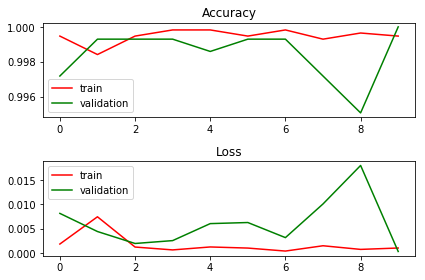

In [69]:
# plotting the results of loss and Accuracy
plt.subplot(211)
plt.title('Accuracy')
plt.plot(history.history['acc'], color='r', label='train')
plt.plot(history.history['val_acc'], color='g', label='validation')
plt.legend(loc='best')

plt.subplot(212)
plt.title('Loss')
plt.plot(history.history['loss'], color='r', label='train')
plt.plot(history.history['val_loss'], color='g', label='validation')
plt.legend(loc='best')

plt.tight_layout()
plt.show()


### Test the model on the test data and output some random predictions and labels for some samples